### Libraries

In [79]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set_style("whitegrid")

#Model librairies

from sklearn.model_selection import train_test_split

#Linear regression from stats model
from statsmodels.formula.api import ols
from statsmodels.api import OLS
from statsmodels.api import add_constant

#Linear regression from sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score



In [20]:
df=pd.read_csv('Dataset_clean_Eng.csv')
df.drop(['Unnamed: 0','Title', 'Initial_publisher','Author', 'Author_secondary',
       'Co_Author','New_date','Total_loans'],axis=1,inplace=True)

In [21]:
todrop=list(df.iloc[:,3:62].columns)
df1=df.drop(todrop,axis=1)

In [22]:
df1.dtypes

Number_locations      int64
Number_Loans_2017     int64
Total_stock           int64
Categories_stat      object
DocType              object
Age                   int64
Language             object
Publisher            object
dtype: object

In [23]:
# Dummies
Dummies_NA=[]
Dummies_NA.extend(['Language','Categories_stat','DocType','Publisher'])


In [24]:
#Transform selected columns into dummies
df1=pd.get_dummies(data=df1, columns=Dummies_NA,drop_first=True)

In [25]:
#Normalization or not? Categorization of Age, stock,location
#Normalisation quand j'utiliserai des algorithmes qui utilisent les distances.

In [ ]:
# Idee :utiliser colonnes libraries avec 1 ou 0 ( livre present ou pas pour faire du hot encoding et utiliser l'info de ces colonnes)

In [27]:
def HotEncod(col):
    df[col]=df[col].map(lambda x:0 if x==0 else 1)
    return None

In [28]:
for col in df.iloc[:,3:62].columns.to_list():
    HotEncod(col)

In [33]:
df=pd.get_dummies(data=df, columns=Dummies_NA,drop_first=True)

<AxesSubplot:>

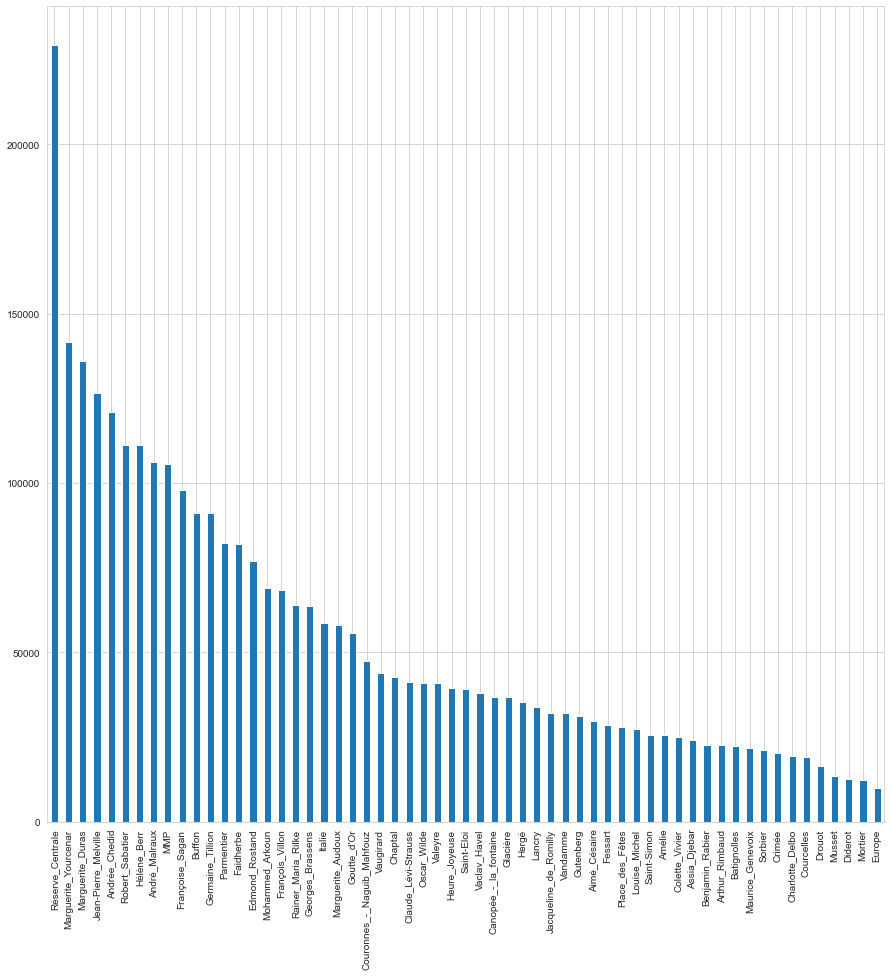

In [40]:
#Number of different documents in each libraries:
fig, axs = plt.subplots(figsize=(15,15)) 
df.iloc[:,3:62].sum().sort_values(ascending=False).plot(kind='bar')

In [41]:
df.iloc[:,3:62].sum().sort_values(ascending=False)

Réserve_Centrale              229307
Marguerite_Yourcenar          141538
Marguerite_Duras              136014
Jean-Pierre_Melville          126742
Andrée_Chedid                 120923
Robert_Sabatier               111343
Hélène_Berr                   111203
André_Malraux                 106263
MMP                           105522
Françoise_Sagan                97887
Buffon                         91154
Germaine_Tillion               91037
Parmentier                     82195
Faidherbe                      82036
Edmond_Rostand                 76933
Mohammed_Arkoun                68945
François_Villon                68475
Rainer_Maria_Rilke             64160
Georges_Brassens               63588
Italie                         58668
Marguerite_Audoux              58151
Goutte_d'Or                    55872
Couronnes_-_Naguib_Mahfouz     47455
Vaugirard                      44026
Chaptal                        42839
Claude_Lévi-Strauss            41304
Oscar_Wilde                    40873
V

In [43]:
df.to_csv('DatasetforModeling.csv')

In [44]:
df.columns

Index(['Number_locations', 'Number_Loans_2017', 'Total_stock', 'Aimé_Césaire',
       'Amélie', 'André_Malraux', 'Andrée_Chedid', 'Arthur_Rimbaud',
       'Assia_Djebar', 'Batignolles',
       ...
       'Publisher_Gallimard', 'Publisher_Glénat', 'Publisher_Hachette',
       'Publisher_Librairie générale française', 'Publisher_Nathan',
       'Publisher_Other', 'Publisher_Pocket',
       'Publisher_Presses universitaires de France', 'Publisher_R. Laffont',
       'Publisher_Éd. du Seuil'],
      dtype='object', length=109)

In [45]:
y=df['Number_Loans_2017']
X=df.drop('Number_Loans_2017',axis=1)

### LINEAR REGRESSION

In [ ]:
# Results with OLS without book AGe
OLS Regression Results
Dep. Variable:	Nombre_de_prêts_2017	R-squared:	0.599
Model:	OLS	Adj. R-squared:	0.599
Method:	Least Squares	F-statistic:	2.708e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:27:12	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815485	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust		

In [46]:
model=OLS(y,X)
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Number_Loans_2017   R-squared (uncentered):                   0.661
Model:                            OLS   Adj. R-squared (uncentered):              0.661
Method:                 Least Squares   F-statistic:                          1.452e+04
Date:                Fri, 11 Sep 2020   Prob (F-statistic):                        0.00
Time:                        22:34:05   Log-Likelihood:                     -3.8045e+06
No. Observations:              798386   AIC:                                  7.609e+06
Df Residuals:                  798279   BIC:                                  7.611e+06
Df Model:                         107                                                  
Covariance Type:            nonrobust                                                  
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Number_locations                                  1.222e+10   2.35e+10      0.521      0.602   -3.38e+10    5.82e+10
Total_stock                                          1.7028      0.002    705.481      0.000       1.698       1.708
Aimé_Césaire                                     -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Amélie                                           -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
André_Malraux                                    -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Andrée_Chedid                                    -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Arthur_Rimbaud                                   -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Assia_Djebar                                     -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Batignolles                                      -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Benjamin_Rabier                                  -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Buffon                                           -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Canopée_-_la_fontaine                            -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Chaptal                                          -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Charlotte_Delbo                                  -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Claude_Lévi-Strauss                              -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Colette_Vivier                                   -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Courcelles                                       -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Couronnes_-_Naguib_Mahfouz                       -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Crimée                                           -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Diderot                                          -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Drouot                                           -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Edmond_Rostand                                   -1.222e+10   2.35e+10     -0.521      0.602   -5.82e+10    3.38e+10
Europe                                           -1.222e+10

In [ ]:
OLS Regression Results
Dep. Variable:	Number_Loans_2017	R-squared (uncentered):	0.661
Model:	OLS	Adj. R-squared (uncentered):	0.661
Method:	Least Squares	F-statistic:	1.452e+04
Date:	Fri, 11 Sep 2020	Prob (F-statistic):	0.00
Time:	22:34:05	Log-Likelihood:	-3.8045e+06
No. Observations:	798386	AIC:	7.609e+06
Df Residuals:	798279	BIC:	7.611e+06
Df Model:	107		
Covariance Type:	nonrobust		
coef	std err	t	P>|t|	[0.025	0.975]
Number_locations	1.222e+10	2.35e+10	0.521	0.602	-3.38e+10	5.82e+10
Total_stock	1.7028	0.002	705.481	0.000	1.698	1.708
Aimé_Césaire	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Amélie	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
André_Malraux	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Andrée_Chedid	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Arthur_Rimbaud	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Assia_Djebar	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Batignolles	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Benjamin_Rabier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Buffon	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Canopée_-_la_fontaine	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Chaptal	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Charlotte_Delbo	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Claude_Lévi-Strauss	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Colette_Vivier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Courcelles	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Couronnes_-_Naguib_Mahfouz	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Crimée	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Diderot	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Drouot	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Edmond_Rostand	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Europe	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Faidherbe	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Fessart	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
François_Villon	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Françoise_Sagan	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Georges_Brassens	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Germaine_Tillion	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Glacière	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Goutte_d'Or	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Gutenberg	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Hélène_Berr	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Hergé	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Heure_Joyeuse	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Italie	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Jacqueline_de_Romilly	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Jean-Pierre_Melville	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Lancry	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Louise_Michel	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Marguerite_Audoux	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Marguerite_Duras	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Marguerite_Yourcenar	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Maurice_Genevoix	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
MMP	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Mohammed_Arkoun	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Mortier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Musset	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Oscar_Wilde	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Parmentier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Place_des_Fêtes	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Rainer_Maria_Rilke	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Réserve_Centrale	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Robert_Sabatier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Saint-Eloi	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Saint-Simon	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Sorbier	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Vaclav_Havel	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Valeyre	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Vandamme	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Vaugirard	-1.222e+10	2.35e+10	-0.521	0.602	-5.82e+10	3.38e+10
Age	0.0764	0.003	27.952	0.000	0.071	0.082
Language_English	0.1301	0.394	0.331	0.741	-0.641	0.902
Language_French	-2.0460	0.372	-5.499	0.000	-2.775	-1.317
Language_German	-1.1684	0.495	-2.361	0.018	-2.138	-0.199
Language_Italian	-0.0370	0.496	-0.075	0.941	-1.009	0.935
Language_Japanese	2.0688	0.982	2.106	0.035	0.144	3.994
Language_Latin	-0.9145	0.640	-1.429	0.153	-2.169	0.340
Language_Other	-0.2119	0.405	-0.523	0.601	-1.006	0.582
Language_Portuguese	-0.6668	0.668	-0.999	0.318	-1.976	0.642
Language_Spanish	-0.8503	0.520	-1.636	0.102	-1.869	0.169
Language_Unknown	-0.2232	0.395	-0.565	0.572	-0.998	0.551
Categories_stat_CNAM Cinema nord-americain	-1.9684	0.355	-5.540	0.000	-2.665	-1.272
Categories_stat_D911 Guides de voyage, tourisme	-3.2134	0.402	-7.993	0.000	-4.001	-2.425
Categories_stat_LALB Albums	-8.9932	0.357	-25.164	0.000	-9.694	-8.293
Categories_stat_LBDE Bandes dessinees	12.6306	0.411	30.740	0.000	11.825	13.436
Categories_stat_LBRI Litterature britannique	-9.8571	0.358	-27.541	0.000	-10.559	-9.156
Categories_stat_LFRA Litterature francaise	-8.5469	0.322	-26.552	0.000	-9.178	-7.916
Categories_stat_LMAN Mangas	3.4945	0.468	7.467	0.000	2.577	4.412
Categories_stat_LNAM Litterature nord-americaine	-9.8917	0.347	-28.486	0.000	-10.572	-9.211
Categories_stat_Other	-8.4662	0.303	-27.921	0.000	-9.061	-7.872
DocType_BoardGames	-7.2903	1.599	-4.560	0.000	-10.424	-4.157
DocType_Book	1.3793	0.340	4.060	0.000	0.713	2.045
DocType_CD	3.5616	0.355	10.027	0.000	2.865	4.258
DocType_Cannot_be_borrowed	3.8067	0.959	3.970	0.000	1.927	5.686
DocType_DVD	8.0977	0.362	22.356	0.000	7.388	8.808
DocType_Diapo	1.4904	1.541	0.967	0.333	-1.529	4.510
DocType_Magazine	-17.0547	0.664	-25.683	0.000	-18.356	-15.753
DocType_Map	11.0979	0.900	12.327	0.000	9.333	12.863
DocType_Other	3.4221	0.490	6.982	0.000	2.461	4.383
DocType_Partition	3.9319	0.404	9.730	0.000	3.140	4.724
DocType_VHS	0.5547	12.706	0.044	0.965	-24.349	25.458
DocType_Videogames	-3.2115	1.299	-2.472	0.013	-5.758	-0.665
DocType_Vynile	3.2658	0.821	3.979	0.000	1.657	4.874
Publisher_Actes Sud	2.1650	0.550	3.938	0.000	1.087	3.243
Publisher_Casterman	-3.4427	0.543	-6.342	0.000	-4.507	-2.379
Publisher_Fayard	2.3032	0.503	4.580	0.000	1.318	3.289
Publisher_Flammarion	1.7049	0.428	3.983	0.000	0.866	2.544
Publisher_Gallimard	1.9378	0.377	5.145	0.000	1.200	2.676
Publisher_Glénat	4.5670	0.558	8.187	0.000	3.474	5.660
Publisher_Hachette	6.4972	0.537	12.104	0.000	5.445	7.549
Publisher_Librairie générale française	3.7939	0.542	6.999	0.000	2.731	4.856
Publisher_Nathan	4.1973	0.538	7.800	0.000	3.143	5.252
Publisher_Other	2.9822	0.333	8.964	0.000	2.330	3.634
Publisher_Pocket	5.7989	0.542	10.690	0.000	4.736	6.862
Publisher_Presses universitaires de France	5.2872	0.495	10.687	0.000	4.318	6.257
Publisher_R. Laffont	2.0916	0.539	3.880	0.000	1.035	3.148
Publisher_Éd. du Seuil	1.6072	0.518	3.105	0.002	0.593	2.622


In [ ]:
#Results presentation Ironhack july
LS Regression Results 
Dep. Variable:	Nombre_de_prêts_2017	R-squared (uncentered):	0.621
Model:	OLS	Adj. R-squared (uncentered):	0.621
Method:	Least Squares	F-statistic:	2.964e+04
Date:	Mon, 20 Jul 2020	Prob (F-statistic):	0.00
Time:	02:18:40	Log-Likelihood:	-3.9296e+06
No. Observations:	815531	AIC:	7.859e+06
Df Residuals:	815486	BIC:	7.860e+06
Df Model:	45		
Covariance Type:	nonrobust	

In [51]:
model2=OLS(y,add_constant(X))
model_fit2=model2.fit()
model_fit2.summary()
# R-quared is pretty good. We notice that the information brings by the Libraries columns is not relevant for the moedel (P-value>5%)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_Loans_2017   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                 1.331e+04
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:57:23   Log-Likelihood:            -3.8045e+06
No. Observations:              798386   AIC:                         7.609e+06
Df Residuals:                  798278   BIC:                         7.611e+06
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                1.2525      0.801      1.564      0.118      -0.317       2.822
Number_locations                                  5.188e+09   1.06e+10      0.489      0.625   -1.56e+10     2.6e+10
Total_stock                                          1.7026      0.002    710.735      0.000       1.698       1.707
Aimé_Césaire                                     -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Amélie                                           -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
André_Malraux                                    -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Andrée_Chedid                                    -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Arthur_Rimbaud                                   -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Assia_Djebar                                     -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Batignolles                                      -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Benjamin_Rabier                                  -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Buffon                                           -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Canopée_-_la_fontaine                            -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Chaptal                                          -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Charlotte_Delbo                                  -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Claude_Lévi-Strauss                              -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Colette_Vivier                                   -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Courcelles                                       -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Couronnes_-_Naguib_Mahfouz                       -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Crimée                                           -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Diderot                                          -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Drouot                                           -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Edmond_Rostand                                   -5.188e+09   1.06e+10     -0.489      0.625    -2.6e+10    1.56e+10
Europe                                   

In [58]:
#I will work without columns libraries for next models.
y1=df1['Number_Loans_2017']
X1=df1.drop('Number_Loans_2017',axis=1)


In [60]:
model3=OLS(y1,add_constant(X1)).fit()

model3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_Loans_2017   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 2.511e+04
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:11:39   Log-Likelihood:            -3.8410e+06
No. Observations:              798386   AIC:                         7.682e+06
Df Residuals:                  798336   BIC:                         7.683e+06
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                4.4095      0.832      5.302      0.000       2.780       6.040
Number_locations                                     2.3866      0.007    358.579      0.000       2.374       2.400
Total_stock                                          1.7312      0.002    692.838      0.000       1.726       1.736
Age                                                  0.0433      0.003     16.423      0.000       0.038       0.048
Language_English                                    -2.6477      0.493     -5.374      0.000      -3.613      -1.682
Language_French                                     -4.4427      0.479     -9.284      0.000      -5.381      -3.505
Language_German                                     -4.2765      0.583     -7.340      0.000      -5.418      -3.135
Language_Italian                                    -3.5595      0.583     -6.102      0.000      -4.703      -2.416
Language_Japanese                                   -0.3232      1.060     -0.305      0.760      -2.400       1.754
Language_Latin                                      -5.4763      0.722     -7.581      0.000      -6.892      -4.060
Language_Other                                      -3.4457      0.503     -6.848      0.000      -4.432      -2.460
Language_Portuguese                                 -2.9222      0.749     -3.900      0.000      -4.391      -1.454
Language_Spanish                                    -3.2738      0.606     -5.406      0.000      -4.461      -2.087
Language_Unknown                                    -2.7143      0.494     -5.491      0.000      -3.683      -1.746
Categories_stat_CNAM Cinema nord-americain          -2.9409      0.387     -7.604      0.000      -3.699      -2.183
Categories_stat_D911 Guides de voyage, tourisme     -7.4936      0.442    -16.954      0.000      -8.360      -6.627
Categories_stat_LALB Albums                         -6.8422      0.396    -17.268      0.000      -7.619      -6.066
Categories_stat_LBDE Bandes dessinees               10.8027      0.551     19.616      0.000       9.723      11.882
Categories_stat_LBRI Litterature britannique       -13.2553      0.400    -33.101      0.000     -14.040     -12.470
Categories_stat_LFRA Litterature francaise         -11.6750      0.365    -31.943      0.000     -12.391     -10.959
Categories_stat_LMAN Mangas                          3.7406      0.598      6.259      0.000       2.569       4.912
Categories_stat_LNAM Litterature nord-americaine   -12.6834      0.391    -32.460      0.000     -13.449     -11.918
Categories_stat_Other                              -12.1066      0.348    -34.759      0.000     -12.789     -11.424
DocType_BoardGames                       

### P-Hacking

In [52]:
def func(column, X=X,y=y):
    if column:
        X=X.drop(column, axis=1)
    
    #buildthemodel
    model=OLS(y,add_constant(X))
    model_fit=model.fit()
    display(model_fit.summary())
    return X

In [67]:
#Dropped columns :  Language_Japanese,DocType_BoardGames,DocType_Cannot_be_borrowed,DocType_Other,DocType_VHS,Publisher_Fayard,Publisher_Éd. du Seuil
X1=func('Publisher_Éd. du Seuil',X1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_Loans_2017   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 2.929e+04
Date:                Mon, 14 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:44:54   Log-Likelihood:            -3.8410e+06
No. Observations:              798386   AIC:                         7.682e+06
Df Residuals:                  798343   BIC:                         7.683e+06
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                                4.4643      0.660      6.761      0.000       3.170       5.758
Number_locations                                     2.3866      0.007    358.837      0.000       2.374       2.400
Total_stock                                          1.7312      0.002    692.905      0.000       1.726       1.736
Age                                                  0.0432      0.003     16.404      0.000       0.038       0.048
Language_English                                    -2.5686      0.443     -5.803      0.000      -3.436      -1.701
Language_French                                     -4.3669      0.428    -10.214      0.000      -5.205      -3.529
Language_German                                     -4.1882      0.541     -7.742      0.000      -5.248      -3.128
Language_Italian                                    -3.4825      0.542     -6.429      0.000      -4.544      -2.421
Language_Latin                                      -5.3971      0.689     -7.834      0.000      -6.747      -4.047
Language_Other                                      -3.3669      0.454     -7.415      0.000      -4.257      -2.477
Language_Portuguese                                 -2.8437      0.717     -3.964      0.000      -4.250      -1.438
Language_Spanish                                    -3.1926      0.566     -5.642      0.000      -4.302      -2.083
Language_Unknown                                    -2.6346      0.444     -5.934      0.000      -3.505      -1.764
Categories_stat_CNAM Cinema nord-americain          -2.9432      0.387     -7.611      0.000      -3.701      -2.185
Categories_stat_D911 Guides de voyage, tourisme     -7.4999      0.442    -16.975      0.000      -8.366      -6.634
Categories_stat_LALB Albums                         -6.8667      0.396    -17.354      0.000      -7.642      -6.091
Categories_stat_LBDE Bandes dessinees               10.7937      0.461     23.409      0.000       9.890      11.697
Categories_stat_LBRI Litterature britannique       -13.2624      0.400    -33.138      0.000     -14.047     -12.478
Categories_stat_LFRA Litterature francaise         -11.6818      0.365    -31.982      0.000     -12.398     -10.966
Categories_stat_LMAN Mangas                          3.7322      0.513      7.272      0.000       2.726       4.738
Categories_stat_LNAM Litterature nord-americaine   -12.6941      0.390    -32.511      0.000     -13.459     -11.929
Categories_stat_Other                              -12.1098      0.348    -34.789      0.000     -12.792     -11.428
DocType_Book                                        -2.1725      0.264     -8.242      0.000      -2.689      -1.656
DocType_CD                               

In [ ]:
X.shape,df1.shape

###  Assumption tester for OLS model

In [69]:
#Source Eldiias
class Assumption_Tester_OLS:
    """
   X - Pandas DataFrame with numerical values. Independent Variable
   y - Series with numerical values. Dependent Variable
    
    Tests a linear regression on the model to see if assumptions are being met

    """
    
    from sklearn.linear_model import LinearRegression
    
    def __init__(self, X,y):
        from numpy import ndarray
        from pandas import concat
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series

        if type(X) == ndarray:
            self.features = ['X'+str(feature+1) for feature in range(X.shape[1])]
        elif type(X) == DataFrame:
            self.features=X.columns.to_list()
        else:
            print('Expected numpy array or pandas dataframe as X')
            return
        if type(y) == ndarray:
            self.output = 'y'
        elif type(y) == DataFrame:
            self.output=y.columns[0]
        elif type(y) == Series:
            self.output=y.name
        else:
            print('Expected numpy array or pandas dataframe as X')
            return

        self.X = X.values if type(X)==DataFrame else X
        self.y=y.iloc[:,0].values if type(y)==DataFrame else y.values if type(y)==Series else y
        
        self.model='not built yet'
        self.r2=0
        self.results={'Satisfied':[],'Potentially':[],'Violated':[]}
    
   
    def fit_model(self):
        from sklearn.linear_model import LinearRegression
        
        print('Fitting linear regression')        
        
        #Multi-threading when needed
        if self.X.shape[0] > 100000:
            self.model = LinearRegression(n_jobs=-1)
        else:
            self.model = LinearRegression()
        self.model.fit(self.X, self.y)
        
        self.predictions = self.model.predict(self.X)
        self.resid = self.y - self.predictions
        
        
    def build_model(self):
        self.fit_model()
        
        # Returning linear regression R^2 and coefficients before performing diagnostics
        self.r2 = self.model.score(self.X, self.y)
        print()
        print('R^2:', self.r2, '\n')
        print('Coefficients')
        print('-------------------------------------')
        print('Intercept:', self.model.intercept_)
        for idx,feature in enumerate(self.model.coef_):
            print(f'{self.features[idx]}: {round(feature,2)}')

    def linearity(self):
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        from pandas import concat
        from numpy import arange
        from pandas.core.frame import DataFrame
        from pandas.core.series import Series        
        import seaborn as sns
        sns.set()
        import matplotlib.pyplot as plt
        
        if type(self.model)==str:
            self.fit_model()
        
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.regplot(self.y,self.predictions, fit_reg=False)
        
        # Plotting the diagonal line
        line_coords = arange(min(self.y.min(),self.predictions.min()), max(self.y.max(),self.predictions.max()))
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term \n\t\tor using box-cox transformation to make X or y follow normal distribution')
        
        print('\n\n\nBuilding a correlation table')
        print('\n=======================================================================================')
        df=concat([DataFrame(self.X),Series(self.y)],axis=1)
        df.columns=self.features+[self.output]
        df_corr=df[df.nunique()[df.nunique()>2].index].corr()[self.output].drop(self.output)
        
        print(f'\nParameters that are most likely VIOLATE linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)<0.25])

        print(f'\nParameters that are most likely FOLLOW linearity assumption and their correlation with {self.output}')
        display(df_corr[abs(df_corr)>=0.25])
        
        
        if df_corr[abs(df_corr)<0.25].shape[0]==0:
            self.results['Satisfied'].append('Linearity')
        elif df_corr[abs(df_corr)>=0.25].shape[0]==0:
            self.results['Violated'].append('Linearity')
        else:
            self.results['Potentially'].append('Linearity')
        
    def multicollinearity(self):
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
        import matplotlib.pyplot as plt
        import seaborn as sns
        from pandas.core.frame import DataFrame
        sns.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 2: Little to no multicollinearity among predictors')
        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(DataFrame(self.X, columns=self.features).corr(), annot=len(self.features)<10, center=0, cmap=sns.diverging_palette(220, 20, as_cmap=True))
        plt.title('Correlation of Variables')
        plt.show()
        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')
        # Gathering the VIF for each variable
        vifs = {i:VIF(self.X, idx) for idx,i in enumerate(self.features)}
        vifs = dict(sorted(vifs.items(), key=lambda x: x[1], reverse=True))
        for key, vif in vifs.items():
            print(f'{key}: {vif}')
        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in vifs.values() if vif > 10])
        definite_multicollinearity = sum([1 for vif in vifs.values() if vif > 100])
        print()
        print(f'{possible_multicollinearity} cases of possible multicollinearity')
        print(f'{definite_multicollinearity} cases of definite multicollinearity')
        print()
        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
                self.results['Satisfied'].append('Multicollinearity')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
                self.results['Potentially'].append('Multicollinearity')

        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
            self.results['Violated'].append('Multicollinearity')
            

    
    def autocorrelation(self):
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson        
        
        if type(self.model)==str:
            self.fit_model()
        print('\n=======================================================================================')
        print('Assumption 3: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(self.resid)
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            self.results['Violated'].append('Autocorrelation')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')
            self.results['Satisfied'].append('Autocorrelation')
            

    def homoskedasticity(self,p_value_thresh=0.05):
        """
        Homoskedasticity: Assumes that the errors exhibit constant variance
        """
        
        from statsmodels.stats.diagnostic import het_breuschpagan
        
        import matplotlib.pyplot as plt
        import seaborn
        from numpy import repeat
        seaborn.set()
        
        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 4: Homoskedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=range(self.X.shape[0]), y=self.resid, alpha=0.5)
        plt.plot(repeat(0, self.X.shape[0]), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroskedasticity is apparent, confidence intervals and predictions will be affected')        
        print('\nConsider removing outliers and preprocessing features - nonlinear transformation can help')
        
        lnames=['Lagrange Multiplier', 'pvalue for LM','F stats','pvalue for Fstats']
        display({lnames[idx]:het_breuschpagan(self.resid,self.X)[idx] for idx in range(4)})
        if het_breuschpagan(self.resid,self.X)[3] < p_value_thresh:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption potentially not satisfied', '\n')
            self.results['Potentially'].append('Autocorrelation')
        else:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption satisfied', '\n')
            self.results['Satisfied'].append('Autocorrelation')

       
        
    def normality_resid(self,p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        from scipy.stats import probplot
        import pylab
        import matplotlib.pyplot as plt
        import seaborn as sns
        from numpy import quantile,logical_or
        sns.set()

        if type(self.model)==str:
            self.fit_model()
            
        print('\n=======================================================================================')
        print('Assumption 5: The error terms are kinda normally distributed')
        print()
        print('Using the Anderson-Darling test for normal distribution')
        # Performing the test on the residuals
        p_value = normal_ad(self.resid)[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(self.resid)
        plt.show()
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
            self.results['Satisfied'].append('Normality')
        else:
            print('Assumption not satisfied')
            self.results['Violated'].append('Normality')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
    
    
        print('Building a probability plot')
        quantiles=probplot(self.resid, dist='norm', plot=pylab);
        plt.show()
        qqq=(quantiles[0][1]-quantiles[0][1].mean())/quantiles[0][1].std()-quantiles[0][0]
        q75=quantile(qqq,0.75)
        q25=quantile(qqq,0.25)

        outliers_share=(logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()/qqq.shape[0]).round(3)
        if outliers_share<0.005:
            print('Assumption can be considered as satisfied.')
            self.results['Satisfied'].append('Sub-Normality')
        elif outliers_share<0.05:
            self.results['Potentially'].append('Sub-Normality')
            print(f'\nIn your dataset you quite fat tails. You have {outliers_share} potential outliers ({logical_or(qqq>q75+(q75-q25)*1.7, qqq<q25-(q75-q25)*1.7).sum()} rows)')
        else:
            print(f'\nIn fact outliers are super significant. Probably it is better to split your dataset into 2 different ones.')
            self.results['Violated'].append('Sub-Normality')


    def run_all(self):
        self.build_model()
        self.linearity()
        self.multicollinearity()
        self.autocorrelation()
        self.homoskedasticity()
        self.normality_resid()
        display(self.results)





### Assumptions check

In [70]:
tester=Assumption_Tester_OLS(X1,y1)

Fitting linear regression

R^2: 0.6064771250228149 

Coefficients
-------------------------------------
Intercept: 4.464311886015102
Number_locations: 2.39
Total_stock: 1.73
Age: 0.04
Language_English: -2.57
Language_French: -4.37
Language_German: -4.19
Language_Italian: -3.48
Language_Latin: -5.4
Language_Other: -3.37
Language_Portuguese: -2.84
Language_Spanish: -3.19
Language_Unknown: -2.63
Categories_stat_CNAM Cinema nord-americain: -2.94
Categories_stat_D911 Guides de voyage, tourisme: -7.5
Categories_stat_LALB Albums: -6.87
Categories_stat_LBDE Bandes dessinees: 10.79
Categories_stat_LBRI Litterature britannique: -13.26
Categories_stat_LFRA Litterature francaise: -11.68
Categories_stat_LMAN Mangas: 3.73
Categories_stat_LNAM Litterature nord-americaine: -12.69
Categories_stat_Other: -12.11
DocType_Book: -2.17
DocType_CD: -1.56
DocType_DVD: 6.81
DocType_Diapo: -2.74
DocType_Magazine: -20.18
DocType_Map: 3.38
DocType_Partition: 0.92
DocType_Videogames: 2.96
DocType_Vynile: 2.56
Publi

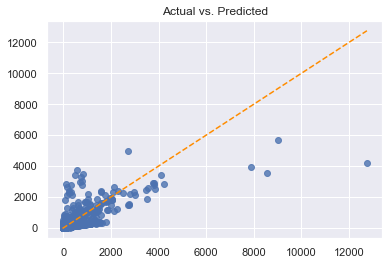

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Number_Loans_2017


Age   -0.107435
Name: Number_Loans_2017, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with Number_Loans_2017


Number_locations    0.583164
Total_stock         0.714549
Name: Number_Loans_2017, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


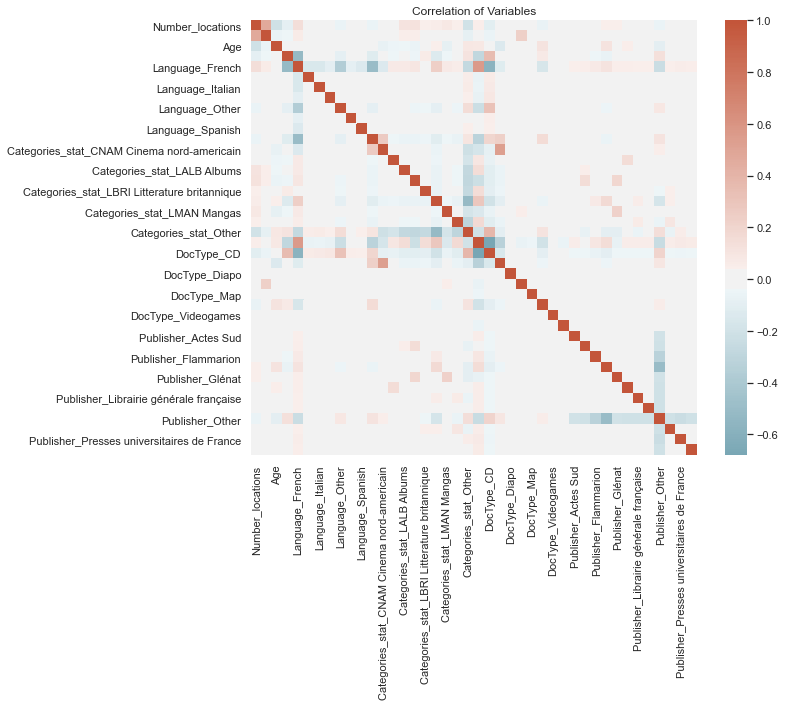

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Language_French: 63.78736412733976
Categories_stat_Other: 52.44388664366388
Publisher_Other: 38.43115624961892
DocType_Book: 31.429833357172065
DocType_CD: 13.96050792464515
Language_English: 11.875762157525008
Language_Unknown: 11.126943410888304
Categories_stat_LFRA Litterature francaise: 10.155098714923342
Language_Other: 6.7003667428746505
DocType_DVD: 4.6493053794298795
Categories_stat_LBDE Bandes dessinees: 4.302609468165232
Categories_stat_LNAM Litterature nord-americaine: 4.290285277165378
Categories_stat_LALB Albums: 3.7916101104387123
Categories_stat_LBRI Litterature britannique: 3.61408210077719
Age: 2.540688513111605
DocType_Partition: 2.446594413154575
Publisher_Gallimard: 2.4127751111379085
Categories_stat_CNAM Cinema nord-americain: 2.409258262767182
Categories_stat_LMAN Mangas: 2.37273105962

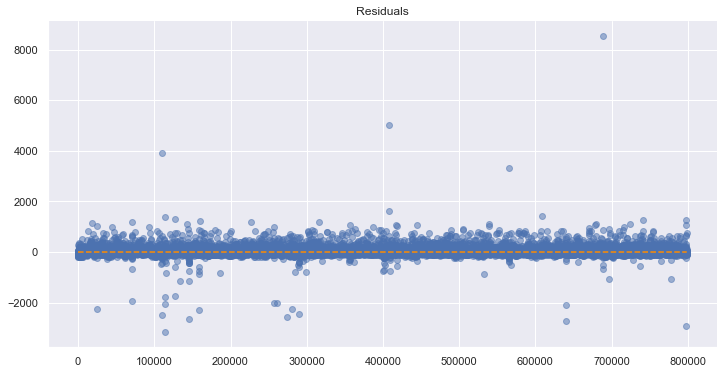

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 180261.17412708187,
 'pvalue for LM': 0.0,
 'F stats': 5543.279593131501,
 'pvalue for Fstats': 0.0}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


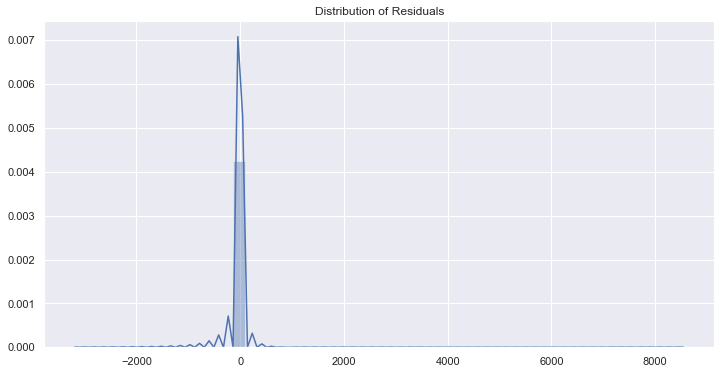


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


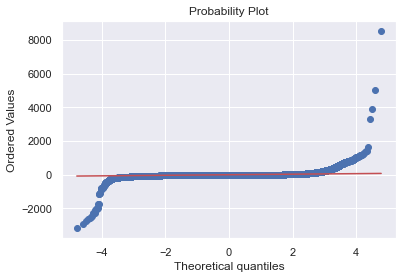

Assumption can be considered as satisfied.


{'Satisfied': ['Autocorrelation', 'Sub-Normality'],
 'Potentially': ['Linearity', 'Multicollinearity', 'Autocorrelation'],
 'Violated': ['Normality']}

In [71]:
tester.run_all()

In [77]:
#Removing muticollinearity
#X1=func('Language_French',X1)
#X1=func('Categories_stat_Other',X1)
X1=func('Publisher_Other',X1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_Loans_2017   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 3.143e+04
Date:                Wed, 16 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:43:52   Log-Likelihood:            -3.8419e+06
No. Observations:              798386   AIC:                         7.684e+06
Df Residuals:                  798346   BIC:                         7.684e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -6.9953      0.263    -26.581      0.000      -7.511      -6.479
Number_locations                                     2.3856      0.007    358.805      0.000       2.373       2.399
Total_stock                                          1.7314      0.003    692.213      0.000       1.726       1.736
Age                                                  0.0410      0.003     15.586      0.000       0.036       0.046
Language_English                                     1.5636      0.130     12.048      0.000       1.309       1.818
Language_German                                     -0.1333      0.338     -0.395      0.693      -0.795       0.529
Language_Italian                                     0.5087      0.339      1.500      0.134      -0.156       1.174
Language_Latin                                      -1.2602      0.544     -2.318      0.020      -2.326      -0.195
Language_Other                                       0.7382      0.165      4.485      0.000       0.416       1.061
Language_Portuguese                                  1.2929      0.580      2.229      0.026       0.156       2.430
Language_Spanish                                     0.9343      0.377      2.477      0.013       0.195       1.673
Language_Unknown                                     1.4537      0.134     10.887      0.000       1.192       1.715
Categories_stat_CNAM Cinema nord-americain           6.1692      0.283     21.794      0.000       5.614       6.724
Categories_stat_D911 Guides de voyage, tourisme      4.6149      0.276     16.693      0.000       4.073       5.157
Categories_stat_LALB Albums                          5.4032      0.189     28.513      0.000       5.032       5.775
Categories_stat_LBDE Bandes dessinees               22.9097      0.305     75.109      0.000      22.312      23.508
Categories_stat_LBRI Litterature britannique        -1.1170      0.197     -5.675      0.000      -1.503      -0.731
Categories_stat_LFRA Litterature francaise           0.3152      0.115      2.742      0.006       0.090       0.541
Categories_stat_LMAN Mangas                         15.8501      0.380     41.715      0.000      15.105      16.595
Categories_stat_LNAM Litterature nord-americaine    -0.6134      0.177     -3.462      0.001      -0.961      -0.266
DocType_Book                                        -2.3029      0.264     -8.732      0.000      -2.820      -1.786
DocType_CD                                          -1.3632      0.275     -4.964      0.000      -1.901      -0.825
DocType_DVD                                         10.0068      0.301     33.287      0.000       9.418      10.596
DocType_Diapo                            

Fitting linear regression

R^2: 0.6056126720655266 

Coefficients
-------------------------------------
Intercept: -6.995271280596674
Number_locations: 2.39
Total_stock: 1.73
Age: 0.04
Language_English: 1.56
Language_German: -0.13
Language_Italian: 0.51
Language_Latin: -1.26
Language_Other: 0.74
Language_Portuguese: 1.29
Language_Spanish: 0.93
Language_Unknown: 1.45
Categories_stat_CNAM Cinema nord-americain: 6.17
Categories_stat_D911 Guides de voyage, tourisme: 4.61
Categories_stat_LALB Albums: 5.4
Categories_stat_LBDE Bandes dessinees: 22.91
Categories_stat_LBRI Litterature britannique: -1.12
Categories_stat_LFRA Litterature francaise: 0.32
Categories_stat_LMAN Mangas: 15.85
Categories_stat_LNAM Litterature nord-americaine: -0.61
DocType_Book: -2.3
DocType_CD: -1.36
DocType_DVD: 10.01
DocType_Diapo: -2.72
DocType_Magazine: -20.17
DocType_Map: 3.51
DocType_Partition: 1.13
DocType_Videogames: 3.1
DocType_Vynile: 2.73
Publisher_Actes Sud: -3.33
Publisher_Casterman: -8.0
Publisher_Flamma

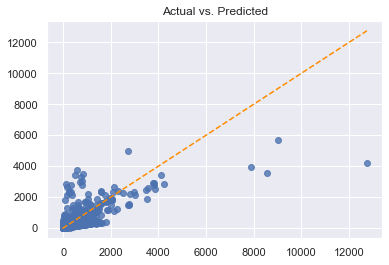

If non-linearity is apparent, consider adding a polynomial term 
		or using box-cox transformation to make X or y follow normal distribution



Building a correlation table


Parameters that are most likely VIOLATE linearity assumption and their correlation with Number_Loans_2017


Age   -0.107435
Name: Number_Loans_2017, dtype: float64


Parameters that are most likely FOLLOW linearity assumption and their correlation with Number_Loans_2017


Number_locations    0.583164
Total_stock         0.714549
Name: Number_Loans_2017, dtype: float64


Assumption 2: Little to no multicollinearity among predictors


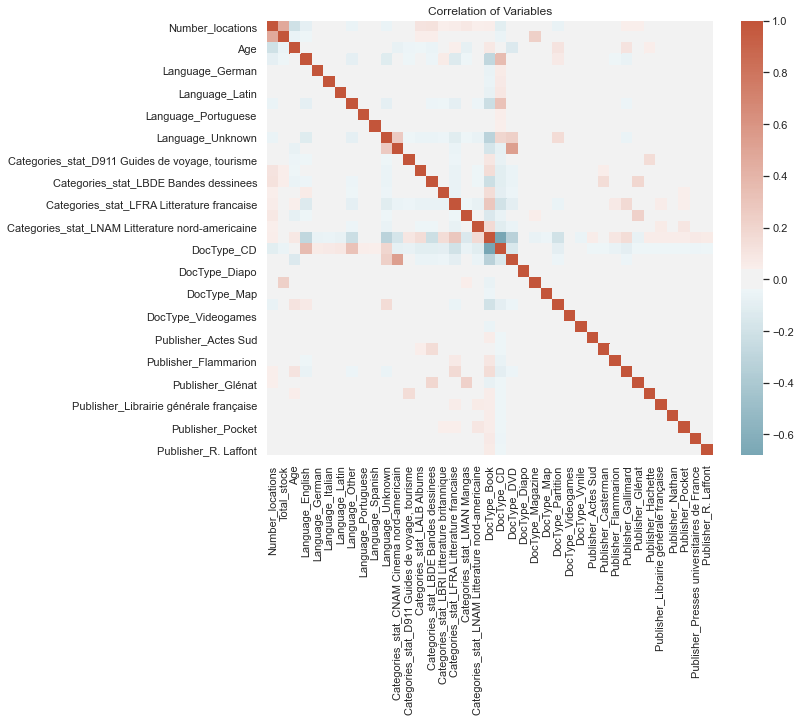

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
DocType_Book: 3.1747962838201422
DocType_CD: 2.820769226457594
Age: 2.504333821898751
Number_locations: 2.0568649229861276
Language_English: 1.6741974118257308
Language_Unknown: 1.6442567597964755
DocType_DVD: 1.5951264591271574
Total_stock: 1.4911212166355257
Categories_stat_CNAM Cinema nord-americain: 1.479342950751838
Language_Other: 1.3975685888569334
Categories_stat_LFRA Litterature francaise: 1.3629981197038645
DocType_Partition: 1.2491062266213027
Categories_stat_LBDE Bandes dessinees: 1.178036523712417
Categories_stat_LNAM Litterature nord-americaine: 1.1481635054391799
Categories_stat_LALB Albums: 1.118764892102463
Categories_stat_LBRI Litterature britannique: 1.1165961434285863
Publisher_Glénat: 1.1038517184842194
Publisher_Gallimard: 1.1030594782023821
Categories_stat_LMAN Mangas: 1.1005055555661

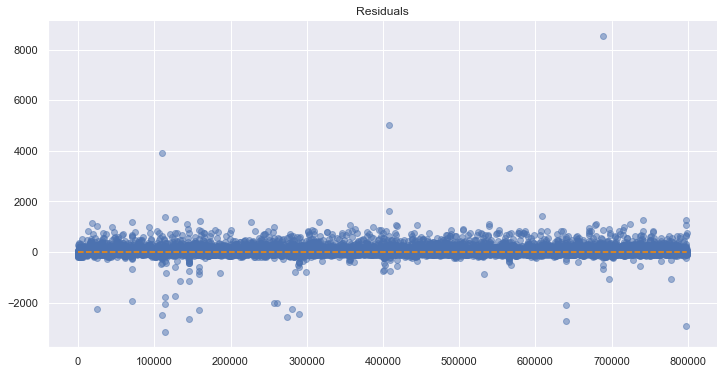

If heteroskedasticity is apparent, confidence intervals and predictions will be affected

Consider removing outliers and preprocessing features - nonlinear transformation can help


{'Lagrange Multiplier': 180241.6072191932,
 'pvalue for LM': 0.0,
 'F stats': 5968.871205048121,
 'pvalue for Fstats': 0.0}

Signs of positive autocorrelation 

Assumption potentially not satisfied 


Assumption 5: The error terms are kinda normally distributed

Using the Anderson-Darling test for normal distribution


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/_adnorm.py:70: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


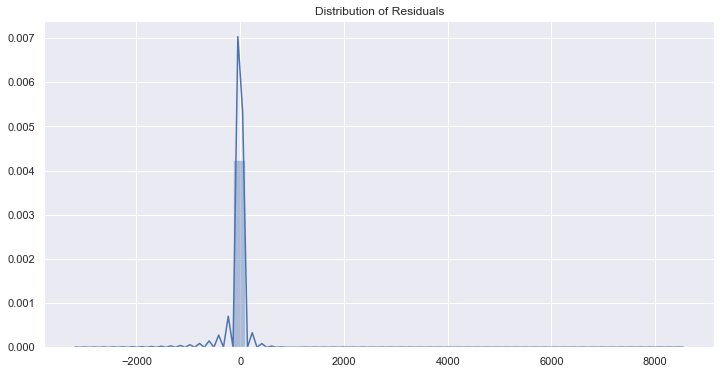


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Building a probability plot


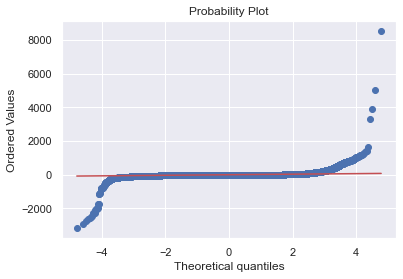

Assumption can be considered as satisfied.


{'Satisfied': ['Multicollinearity', 'Autocorrelation', 'Sub-Normality'],
 'Potentially': ['Linearity', 'Autocorrelation'],
 'Violated': ['Normality']}

In [78]:
tester=Assumption_Tester_OLS(X1,y1)
tester.run_all()

In [108]:
#Saving data resulting from my model testing in 'csv' files
X1.to_csv('X1.csv',index=False)
y1.to_csv('y1.csv',index=False)

In [121]:
X=pd.read_csv('X1.csv')
y=pd.read_csv('y1.csv')

In [ ]:
#X=X.drop(['Categories_stat_Other','Publisher_Other','DocType_Book'],axis=1)

In [123]:
summary=y.describe()
summary

,Number_Loans_2017
count,798386.000000
mean,11.453899
std,47.385149
min,0.000000
25%,0.000000
50%,2.000000
75%,8.000000
max,12745.000000


In [127]:
X.shape,y.shape

((798386, 39), (798386, 1))

In [126]:
model_fit=OLS(y,add_constant(X)).fit()

In [136]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Number_Loans_2017   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                 3.143e+04
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:57:46   Log-Likelihood:            -3.8419e+06
No. Observations:              798386   AIC:                         7.684e+06
Df Residuals:                  798346   BIC:                         7.684e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
const                                               -6.9953      0.263    -26.581      0.000      -7.511      -6.479
Number_locations                                     2.3856      0.007    358.805      0.000       2.373       2.399
Total_stock                                          1.7314      0.003    692.213      0.000       1.726       1.736
Age                                                  0.0410      0.003     15.586      0.000       0.036       0.046
Language_English                                     1.5636      0.130     12.048      0.000       1.309       1.818
Language_German                                     -0.1333      0.338     -0.395      0.693      -0.795       0.529
Language_Italian                                     0.5087      0.339      1.500      0.134      -0.156       1.174
Language_Latin                                      -1.2602      0.544     -2.318      0.020      -2.326      -0.195
Language_Other                                       0.7382      0.165      4.485      0.000       0.416       1.061
Language_Portuguese                                  1.2929      0.580      2.229      0.026       0.156       2.430
Language_Spanish                                     0.9343      0.377      2.477      0.013       0.195       1.673
Language_Unknown                                     1.4537      0.134     10.887      0.000       1.192       1.715
Categories_stat_CNAM Cinema nord-americain           6.1692      0.283     21.794      0.000       5.614       6.724
Categories_stat_D911 Guides de voyage, tourisme      4.6149      0.276     16.693      0.000       4.073       5.157
Categories_stat_LALB Albums                          5.4032      0.189     28.513      0.000       5.032       5.775
Categories_stat_LBDE Bandes dessinees               22.9097      0.305     75.109      0.000      22.312      23.508
Categories_stat_LBRI Litterature britannique        -1.1170      0.197     -5.675      0.000      -1.503      -0.731
Categories_stat_LFRA Litterature francaise           0.3152      0.115      2.742      0.006       0.090       0.541
Categories_stat_LMAN Mangas                         15.8501      0.380     41.715      0.000      15.105      16.595
Categories_stat_LNAM Litterature nord-americaine    -0.6134      0.177     -3.462      0.001      -0.961      -0.266
DocType_Book                                        -2.3029      0.264     -8.732      0.000      -2.820      -1.786
DocType_CD                                          -1.3632      0.275     -4.964      0.000      -1.901      -0.825
DocType_DVD                                         10.0068      0.301     33.287      0.000       9.418      10.596
DocType_Diapo                            

In [ ]:
(y_pred-y).describe().round(2)

In [ ]:
MSE,RMSE, MAE

In [128]:
# Mean squared error
(model_fit.resid**2).mean()

885.5373934458139

In [129]:
# Root Mean Squared Error
(model_fit.resid**2).mean()**0.5

29.757980332102747

In [130]:
# Mean Absolute Error
model_fit.resid.abs().mean()

9.782342401432963

In [131]:
X.head()

,Number_locations,Total_stock,Age,Language_English,Language_German,Language_Italian,Language_Latin,Language_Other,Language_Portuguese,Language_Spanish,...,Publisher_Casterman,Publisher_Flammarion,Publisher_Gallimard,Publisher_Glénat,Publisher_Hachette,Publisher_Librairie générale française,Publisher_Nathan,Publisher_Pocket,Publisher_Presses universitaires de France,Publisher_R. Laffont
0,1,1,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,19,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,3,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,2,33,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
X.columns

Index(['Number_locations', 'Total_stock', 'Age', 'Language_English',
       'Language_German', 'Language_Italian', 'Language_Latin',
       'Language_Other', 'Language_Portuguese', 'Language_Spanish',
       'Language_Unknown', 'Categories_stat_CNAM Cinema nord-americain',
       'Categories_stat_D911 Guides de voyage, tourisme',
       'Categories_stat_LALB Albums', 'Categories_stat_LBDE Bandes dessinees',
       'Categories_stat_LBRI Litterature britannique',
       'Categories_stat_LFRA Litterature francaise',
       'Categories_stat_LMAN Mangas',
       'Categories_stat_LNAM Litterature nord-americaine', 'DocType_Book',
       'DocType_CD', 'DocType_DVD', 'DocType_Diapo', 'DocType_Magazine',
       'DocType_Map', 'DocType_Partition', 'DocType_Videogames',
       'DocType_Vynile', 'Publisher_Actes Sud', 'Publisher_Casterman',
       'Publisher_Flammarion', 'Publisher_Gallimard', 'Publisher_Glénat',
       'Publisher_Hachette', 'Publisher_Librairie générale française',
       'Publis

In [133]:
y

,Number_Loans_2017
0,0
1,0
2,1
3,6
4,3
...,...
798381,6
798382,1
798383,0
798384,1


# Wrapping

In [ ]:
### Target: Testing prediction performance by Doctype
url='DatasetforModeling.csv'

In [135]:
def prepareDataForPrediction(url,col,filter_name):
    #read dataset
    df=pd.read_csv(url)
    # Select the part of the dataset to focus on.
    df=df[df[col]==filter_name]
    
    #Drop unnecessary columns
    df.drop(['Unnamed: 0','Title', 'Initial_publisher','Author', 'Author_secondary',
       'Co_Author','New_date','Total_loans'],axis=1,inplace=True)
        # drop libraries columns
    todrop=list(df.iloc[:,3:62].columns)
    df=df.drop(todrop,axis=1)
    
    #Get dummies for 'Language','Categories_stat','DocType' and'Publisher' columns
    df=pd.get_dummies(data=df, columns=['Language','Categories_stat','DocType','Publisher'],drop_first=True)
   
    X_model=df[['Number_locations', 'Total_stock', 'Age', 'Language_English',
       'Language_German', 'Language_Italian', 'Language_Latin',
       'Language_Other', 'Language_Portuguese', 'Language_Spanish',
       'Language_Unknown', 'Categories_stat_CNAM Cinema nord-americain',
       'Categories_stat_D911 Guides de voyage, tourisme',
       'Categories_stat_LALB Albums', 'Categories_stat_LBDE Bandes dessinees',
       'Categories_stat_LBRI Litterature britannique',
       'Categories_stat_LFRA Litterature francaise',
       'Categories_stat_LMAN Mangas',
       'Categories_stat_LNAM Litterature nord-americaine', 'DocType_Book',
       'DocType_CD', 'DocType_DVD', 'DocType_Diapo', 'DocType_Magazine',
       'DocType_Map', 'DocType_Partition', 'DocType_Videogames',
       'DocType_Vynile', 'Publisher_Actes Sud', 'Publisher_Casterman',
       'Publisher_Flammarion', 'Publisher_Gallimard', 'Publisher_Glénat',
       'Publisher_Hachette', 'Publisher_Librairie générale française',
       'Publisher_Nathan', 'Publisher_Pocket',
       'Publisher_Presses universitaires de France', 'Publisher_R. Laffont']]
    y_model=df['Number_Loans_2017']
    return X_model,y_model

In [ ]:
def test_model(X_model,y_model):
    